# Modeliranje uspeha sletanja Falcon 9: Analiza performansi i predikcija
---

U ovom projektu razvili smo model mašinskog učenja za predviđanje uspešnosti sletanja prve faze rakete **Falcon 9**, koristeći podatke o prethodnim lansiranjima kompanije **SpaceX**. Ponovna upotreba raketa igra ključnu ulogu u smanjenju troškova svemirskih misija, zbog čega je tačno predviđanje ishoda sletanja od velike važnosti za dalji razvoj ovih tehnologija.

Koristili smo različite karakteristike, kao što su masa tereta, tip orbite, mesto lansiranja i tehničke specifikacije boostera, kako bismo trenirali model i napravili predviđanja. Model je evaluiran pomoću metrika kao što su tačnost, preciznost, odziv, F1-score i matrica konfuzije, čime smo dobili jasnu sliku o njegovim performansama.

Nekoliko primera neuspešnih sletanja prikazano je ispod:

![Neuspešno sletanje Falcon 9](../images/crash.gif)

Ovako izgleda raketa **Falcon 9**:

![Raketa Falcon 9](https://drive.google.com/uc?export=view&id=15GKTNnw1eUyWO4V9jaOt3GHap-az4KD8)

Većina neuspešnih sletanja je planirana; **SpaceX** često obavlja kontrolisana sletanja u okeanima radi testiranja i prikupljanja podataka.

---

**Ciljevi projekta:**

1. **Analiza i vizualizacija podataka**
   - Istražiti i vizualizovati ključne karakteristike koje utiču na uspešnost sletanja.
2. **Priprema podataka**
   - Učitati i očistiti podatke o lansiranjima, popuniti nedostajuće vrednosti i pripremiti ih za modelovanje.
3. **Treniranje modela logističke regresije**
   - Kreirati model za predviđanje uspešnosti sletanja na osnovu različitih faktora.
4. **Evaluacija modela**
   - Evaluirati model koristeći relevantne metrike i grafički prikazati rezultate.
5. **Višestruka regresija**
   - Primeniti višestruku linearnu regresiju za predviđanje uspešnosti sletanja.
6. **Poređenje naprednih modela**
   - Uporediti performanse Random Forest, Gradient Boosting i veštačkih neuronskih mreža.
7. **Simulacija lansiranja sa faktorima rizika**
   - Simulirati lansiranja uzimajući u obzir faktore rizika kako bi se procenila verovatnoća uspešnog sletanja.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importovanje biblioteka i definisanje pomoćnih funkcija

---

U ovom delu importovaćemo potrebne biblioteke za analizu podataka, vizualizaciju i mašinsko učenje. Takođe, definisaćemo nekoliko pomoćnih funkcija koje će biti korisne tokom analize i izgradnje modela.


In [8]:
# Importovanje biblioteka za obradu podataka
import pandas as pd
import numpy as np
from google.colab import drive
from imblearn.over_sampling import SMOTE

# Biblioteke za vizualizaciju
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteke za mašinsko učenje
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False):
    """
    Prikazuje confusion matricu kao heatmap.

    Parametri:
    - y_true: stvarne vrednosti klasa
    - y_pred: predviđene vrednosti klasa
    - class_names: lista naziva klasa (opcioni)
    - normalize: normalizacija vrednosti u matrici (True/False)
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def print_classification_report(y_true, y_pred, target_names=None):
    """
    Prikazuje classification report.

    Parametri:
    - y_true: stvarne vrednosti klasa
    - y_pred: predviđene vrednosti klasa
    - target_names: lista naziva klasa (opcioni)
    """
    report = classification_report(y_true, y_pred, target_names=target_names)
    print('Classification Report:')
    print(report)

## Učitavanje skupa podataka

---
U ovom delu ćemo učitati skup podataka o lansiranjima raketa Falcon 9, proveriti strukturu podataka i identifikovati potencijalne nedostatke. Takođe ćemo proveriti da li postoje nedostajuće vrednosti i prilagoditi podatke ako je to potrebno.


In [3]:
# Učitavanje skupa podataka
df = pd.read_csv('/content/drive/MyDrive/dataset_part_2.csv')

# Prikaz prvih nekoliko redova kako bismo dobili uvid u podatke
display(df.head())

# Provera nedostajućih vrednosti po kolonama
print("Provera nedostajućih vrednosti po kolonama:")
print(df.isnull().sum())

# Provera tipova podataka kako bismo bili sigurni da su svi podaci u ispravnom formatu
print("\nStruktura podataka (tipovi kolona):")

df.info()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


Provera nedostajućih vrednosti po kolonama:
FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
Class              0
dtype: int64

Struktura podataka (tipovi kolona):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights        

## Čišćenje podataka - Rešavanje nedostajućih vrednosti
---

U ovom delu ćemo rešiti problem nedostajućih vrednosti u koloni `LandingPad` i pripremiti podatke za dalje analize.


In [4]:
# Prikaz broja nedostajućih vrednosti po kolonama
df.isnull().sum()

# Prikaz strukture podataka (tipovi kolona)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
 17  Class           90 non-null     int64

In [5]:
# Popunjavanje nedostajućih vrednosti u koloni 'LandingPad' sa 'None'
df['LandingPad'].fillna('None', inplace=True)

# Ponovna provera nedostajućih vrednosti
print("\nProvera nedostajućih vrednosti nakon popunjavanja:")
print(df.isnull().sum())


Provera nedostajućih vrednosti nakon popunjavanja:
FlightNumber      0
Date              0
BoosterVersion    0
PayloadMass       0
Orbit             0
LaunchSite        0
Outcome           0
Flights           0
GridFins          0
Reused            0
Legs              0
LandingPad        0
Block             0
ReusedCount       0
Serial            0
Longitude         0
Latitude          0
Class             0
dtype: int64


## Analiza i vizualizacija podataka

---

Sada ćemo analizirati kako različiti faktori utiču na ishod sletanja prve faze rakete Falcon 9. Fokusiraćemo se na karakteristike kao što su `PayloadMass`, `Orbit`, `LaunchSite` i druge, kako bismo identifikovali potencijalno značajne faktore za predviđanje uspeha.

---

Sledeća slika prikazuje nekoliko tipova orbita:

![Orbits](../images/orbits.png)



### Vizualizacija distribucije klasa (uspešno i neuspešno sletanje)

---

Analizom distribucije možemo videti da u našem skupu podataka postoji znatno više uspešnih sletanja, što je važan faktor pri treniranju modela jer neuravnoteženi podaci mogu uticati na njegove performanse.

Ova analiza nam pomaže da procenimo da li je potrebno balansirati podatke pre treniranja modela ili koristiti tehnike koje su robusne na neuravnotežene skupove podataka.

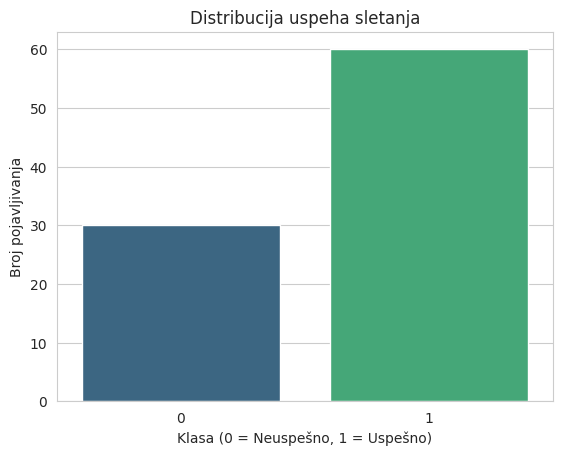

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Class', data=df, hue='Class', palette='viridis', legend=False)
plt.title('Distribucija uspeha sletanja')
plt.xlabel('Klasa (0 = Neuspešno, 1 = Uspešno)')
plt.ylabel('Broj pojavljivanja')
plt.show()

### Analiza distribucije mase tereta u zavisnosti od ishoda sletanja

---

Ova vizualizacija nam omogućava da vidimo kako se mase tereta raspoređuju između uspešnih i neuspešnih misija. Primetno je da rakete sa većom masom tereta generalno imaju veću stopu neuspešnih sletanja, dok rakete sa manjim teretom imaju veću verovatnoću uspešnog sletanja.

Ova analiza pruža vredne uvide o tome kako različite težine tereta mogu uticati na ishod misije, što je važan faktor prilikom treniranja modela za predviđanje uspešnosti sletanja.

Veća masa tereta može zahtevati više goriva i energije za lansiranje, što može uticati na količinu resursa dostupnih za povratak i sletanje prve faze rakete.

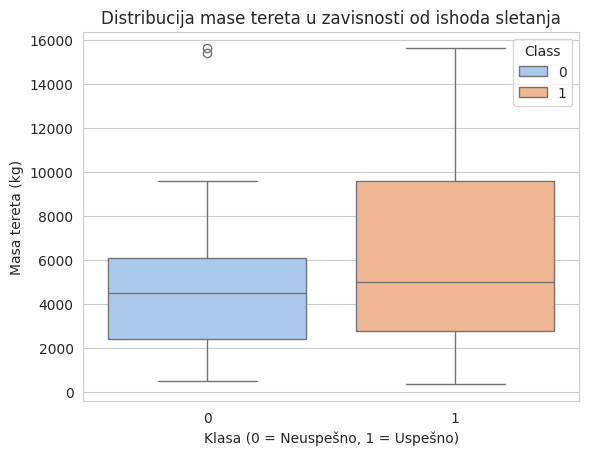

In [ ]:
sns.set_style('whitegrid')
sns.boxplot(x='Class', y='PayloadMass', data=df, hue='Class', palette='pastel', dodge=False)
plt.title('Distribucija mase tereta u zavisnosti od ishoda sletanja')
plt.xlabel('Klasa (0 = Neuspešno, 1 = Uspešno)')
plt.ylabel('Masa tereta (kg)')
plt.show()

### Analiza uticaja orbite na uspešnost sletanja

Ova vizualizacija prikazuje distribuciju uspešnih i neuspešnih sletanja u zavisnosti od orbite, pružajući uvid u to koje orbite povećavaju ili smanjuju šanse za uspešno sletanje.

Analiza pomaže da se bolje razume povezanost između tipa orbite i uspeha sletanja, što je ključno za dalje optimizacije misija i preciznije predviđanje modela.

Veće udaljenosti ili specifični zahtevi određenih orbita mogu uticati na količinu goriva i energije potrebne za misiju, što može smanjiti resurse dostupne za povratak i sletanje rakete. Razumevanje ovih faktora je od suštinskog značaja za planiranje efikasnih i uspešnih svemirskih misija.


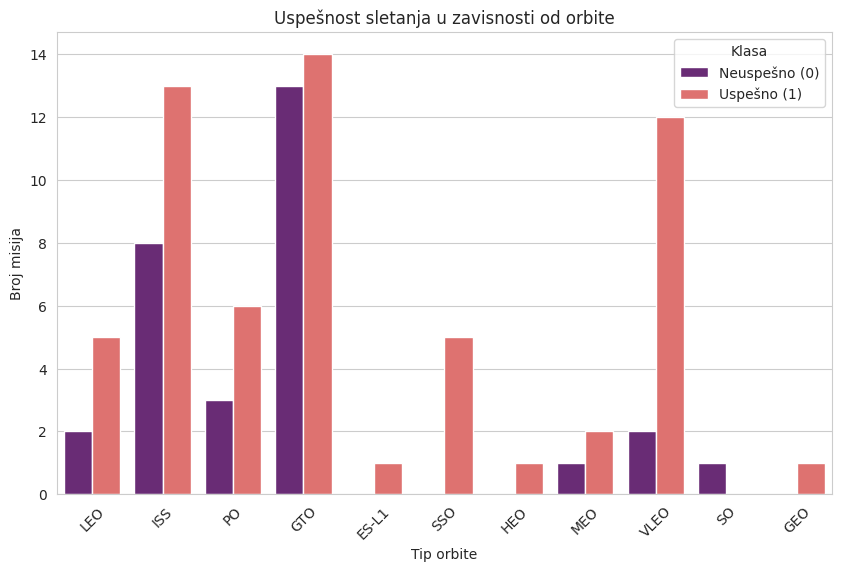

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='Orbit', hue='Class', data=df, palette='magma')
plt.xticks(rotation=45)
plt.title('Uspešnost sletanja u zavisnosti od orbite')
plt.xlabel('Tip orbite')
plt.ylabel('Broj misija')
plt.legend(title='Klasa', labels=['Neuspešno (0)', 'Uspešno (1)'])
plt.show()

### Analiza uticaja orbite i mase tereta na uspešnost sletanja

---

Ova analiza omogućava uvid u to kako masa tereta i orbita zajednički utiču na uspešnost misije. Na primer, određene orbite poput **SSO** (Sun-Sinhrona Orbita) i **VLEO** (Vrlo Niska Zemljina Orbita) pokazuju visok procenat uspešnih sletanja sa manjim masama tereta. S druge strane, teže misije, koje su lansirane u više orbite, generalno imaju manju stopu uspeha.

Ovakvo grupisanje podataka pruža širu sliku odnosa između ovih ključnih faktora i omogućava detaljnije analize koje mogu pomoći u optimizaciji uspešnosti budućih misija.

Veća masa tereta može zahtevati više goriva za postizanje određenih orbita, što može smanjiti količinu goriva dostupnog za povratak i sletanje prve faze rakete. Razumevanje ovih odnosa je ključno za planiranje efikasnih i uspešnih misija.

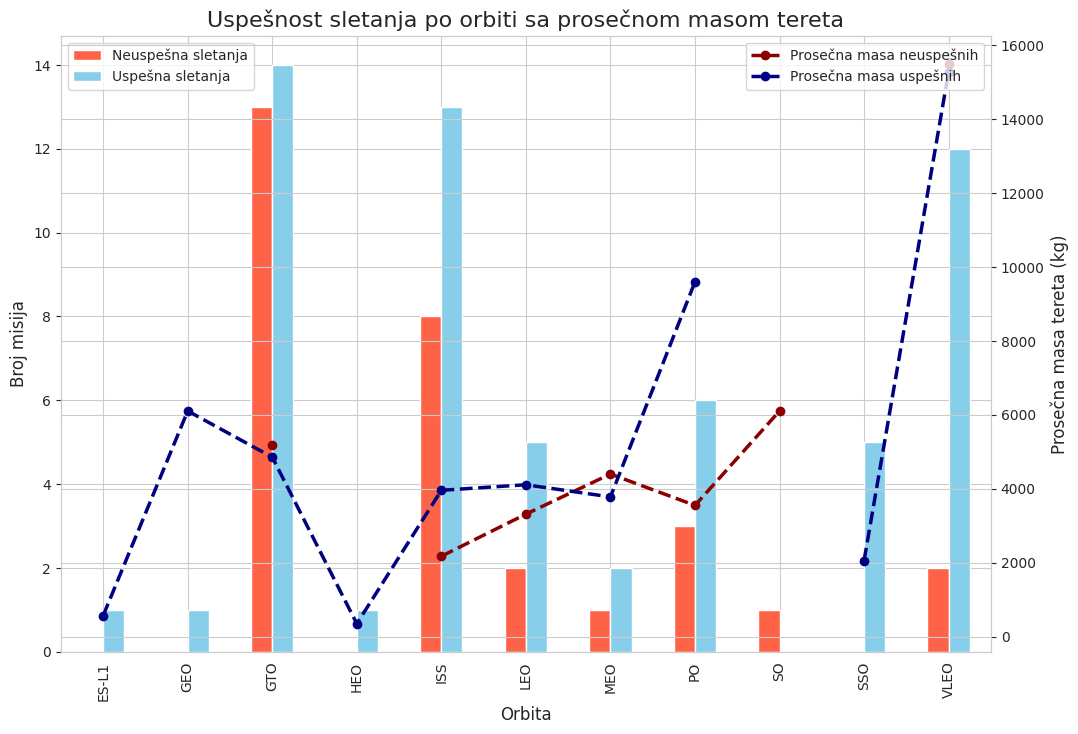

In [ ]:
# Izračunavanje prosečne mase tereta po orbiti i klasi
avg_mass = df.groupby(['Orbit', 'Class'])['PayloadMass'].mean().unstack()

# Grupisanje po orbiti i klasi za broj misija
grouped_data = df.groupby(['Orbit', 'Class'])['FlightNumber'].count().unstack()

# Kreiranje figure i osa
fig, ax = plt.subplots(figsize=(12, 8))

# Kreiranje bar plot-a za broj misija
grouped_data.plot(kind='bar', ax=ax, color=['tomato', 'skyblue'])

# Kreiranje sekundarne ose za prosečnu masu tereta
ax2 = ax.twinx()
avg_mass.plot(kind='line', marker='o', ax=ax2, linewidth=2.5, linestyle='--', color=['darkred', 'navy'])

# Postavljanje naslova i oznaka osa
ax.set_title('Uspešnost sletanja po orbiti sa prosečnom masom tereta', fontsize=16)
ax.set_xlabel('Orbita', fontsize=12)
ax.set_ylabel('Broj misija', fontsize=12)
ax2.set_ylabel('Prosečna masa tereta (kg)', fontsize=12)

# Prilagođavanje legendi
ax.legend(['Neuspešna sletanja', 'Uspešna sletanja'], loc='upper left')
ax2.legend(['Prosečna masa neuspešnih', 'Prosečna masa uspešnih'], loc='upper right')

# Rotacija oznaka na x-osi radi bolje čitljivosti
plt.xticks(rotation=45)

# Prikazivanje grafikona
plt.show()

## Priprema podataka

---
U ovom delu ćemo pripremiti podatke za treniranje modela. Prvo ćemo izabrati ključne karakteristike za predviđanje uspeha sletanja. Zatim ćemo koristiti **One-Hot Encoding** da kodiramo kategorijske podatke, kao što su `Orbit` i `LaunchSite`. Nakon toga, kombinovaćemo kodirane karakteristike sa numeričkim podacima i podeliti podatke na trening i test skup. Ovo je ključni korak za dalje treniranje modela.


In [9]:
# Importovanje potrebnih biblioteka
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Izbor ključnih karakteristika za model
# Koristimo kolone koje su identifikovane kao relevantne za predviđanje uspeha sletanja
features = df[['PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs']]

# Ciljna promenljiva ('Class' - uspešnost sletanja)
target = df['Class']

# Kodiranje kategorijskih podataka ('Orbit' i 'LaunchSite')
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(features[['Orbit', 'LaunchSite']])

# Kombinovanje kodiranih kategorijskih podataka sa numeričkim karakteristikama
numerical_features = features[['PayloadMass', 'Flights', 'GridFins', 'Reused', 'Legs']].values
X = np.hstack((encoded_features, numerical_features))

# Podela podataka na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Provera ukupnog broja instanci
print("Ukupan broj instanci:", X.shape[0])

# Provera dimenzija podataka nakon kodiranja i podele
print("Dimenzije trening skupa:", X_train.shape)
print("Dimenzije test skupa:", X_test.shape)


Ukupan broj instanci: 90
Dimenzije trening skupa: (72, 19)
Dimenzije test skupa: (18, 19)


### Balansiranje skupa podataka pomoću SMOTE tehnike
---
Korišćenjem tehnike SMOTE (Synthetic Minority Over-sampling Technique), možemo poboljšati balans između klasa u našem trening skupu. SMOTE funkcioniše kreiranjem sintetičkih instanci manjinske klase, što omogućava modelima mašinskog učenja da nauče robustnije karakteristike i poboljšaju svoju generalizaciju na manje zastupljene klase.

Balansiranjem klasa, modeli postaju manje pristrasni i tačniji u predviđanjima, što je posebno važno u situacijama gde je precizna klasifikacija ključna, kao što je predviđanje uspešnosti sletanja raketa. Ova tehnika se posebno preporučuje kada postoji velika neravnoteža u distribuciji klasa, kao što smo uočili u našem skupu podataka.

In [10]:
# Pretpostavimo da su 'features' i 'target' već definisani ranije u kodu
features = df[['PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs']]
target = df['Class']

# Kodiranje kategorijskih podataka i priprema za model
X = pd.get_dummies(features, drop_first=True)
y = target

# Deljenje podataka na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicijalizacija i primena SMOTE-a
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Provera broja instanci po klasama nakon primene SMOTE-a
print('Distribucija klasa u balansiranom trening skupu:')
print(pd.Series(y_train_balanced).value_counts())

Distribucija klasa u balansiranom trening skupu:
Class
1    46
0    46
Name: count, dtype: int64


## Treniranje modela logističke regresije

---

Nakon što smo podelili podatke na trening i test skup, sada ćemo trenirati model logističke regresije. Nakon treniranja modela, izvršićemo evaluaciju koristeći tačnost (accuracy), izveštaj klasifikacije (classification report) i matricu konfuzije (confusion matrix) kako bismo procenili performanse modela.

In [ ]:
# Importovanje potrebnih biblioteka
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Kreiranje i treniranje modela logističke regresije sa balansiranim podacima
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Predviđanje na test skupu
y_pred = model.predict(X_test)

# Evaluacija modela
accuracy = accuracy_score(y_test, y_pred)
print(f"Tačnost modela: {accuracy * 100:.2f}%\n")

# Prikaz izveštaja klasifikacije
print("Izveštaj klasifikacije:")
print(classification_report(y_test, y_pred))

# Prikaz matrice konfuzije
print("Matrica konfuzije:")
print(confusion_matrix(y_test, y_pred))

Tačnost modela: 88.89%

Izveštaj klasifikacije:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.93      0.93      0.93        14

    accuracy                           0.89        18
   macro avg       0.84      0.84      0.84        18
weighted avg       0.89      0.89      0.89        18

Matrica konfuzije:
[[ 3  1]
 [ 1 13]]


## Vizualizacija performansi modela

### Vizualizacija performansi modela: Preciznost, Odziv i F1-Score

---
Ova vizualizacija prikazuje ključne metrike koje procenjuju performanse modela u klasifikaciji uspešnih i neuspešnih sletanja. Vizualizovane su:

- **Preciznost (Precision)**: Procenat tačnih pozitivnih predviđanja, tj. koliko su tačne predikcije modela za uspešna sletanja.

- **Odziv (Recall)**: Procenat ispravno identifikovanih uspešnih sletanja, tj. koliko dobro model prepoznaje sve pozitivne primere.

- **F1-Score**: Harmonična sredina preciznosti i odziva, pružajući uravnoteženu procenu performansi modela.

Model pokazuje visoku tačnost u predviđanju uspešnih sletanja sa izuzetno visokim F1-Score-om za klasu 1 (uspešna sletanja), dok za neuspešna sletanja (klasa 0) odziv ostaje niži.

Ove metrike su ključne za procenu koliko je model efikasan u razlikovanju između uspešnih i neuspešnih sletanja, što je od suštinskog značaja za planiranje budućih misija i minimiziranje rizika.


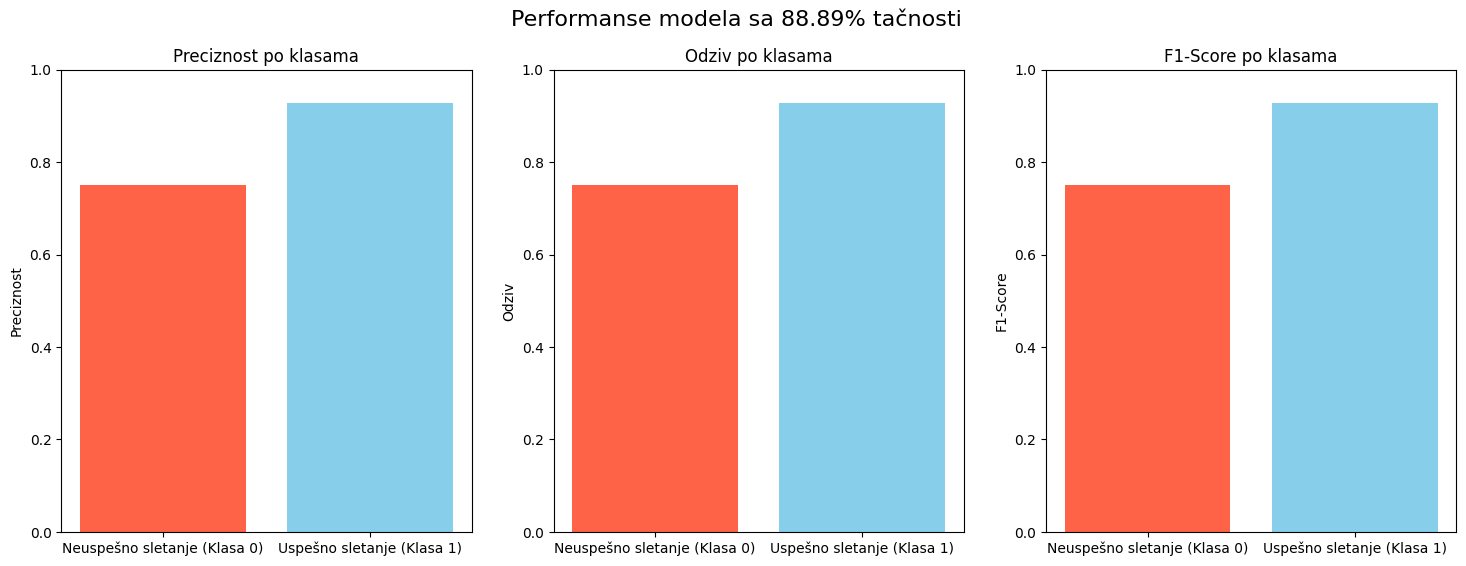

In [ ]:
# Importovanje potrebnih biblioteka za vizualizaciju metrika modela
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Izračunavanje vrednosti preciznosti, odziva i F1-score-a
metrics = precision_recall_fscore_support(y_test, y_pred, average=None)

# Definisanje oznaka za klase i metrike
labels = ['Neuspešno sletanje (Klasa 0)', 'Uspešno sletanje (Klasa 1)']
metrics_labels = ['Preciznost', 'Odziv', 'F1-Score']

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plotovanje preciznosti
ax[0].bar(labels, metrics[0], color=['tomato', 'skyblue'])
ax[0].set_title('Preciznost po klasama')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Preciznost')

# Plotovanje odziva
ax[1].bar(labels, metrics[1], color=['tomato', 'skyblue'])
ax[1].set_title('Odziv po klasama')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Odziv')

# Plotovanje F1-Score-a
ax[2].bar(labels, metrics[2], color=['tomato', 'skyblue'])
ax[2].set_title('F1-Score po klasama')
ax[2].set_ylim(0, 1)
ax[2].set_ylabel('F1-Score')

# Dodavanje naslova
fig.suptitle(f'Performanse modela sa {accuracy * 100:.2f}% tačnosti', fontsize=16)

# Prikazivanje grafika
plt.show()

#### Analiza rezultata

---
**Klasa 0 (Neuspešna sletanja):** Model pokazuje visoku preciznost (**1.00**), ali nešto niži odziv (**0.75**). To znači da, iako su sve predviđene neuspešne misije zaista neuspešne (nema lažno pozitivnih), model ne uspeva da prepozna sve stvarne neuspešne misije (postoje lažno negativni slučajevi).

**Klasa 1 (Uspešna sletanja):** Model je vrlo precizan, sa savršenim odzivom (**1.00**) i visokom preciznošću (**0.93**). To ukazuje da model uspešno identifikuje sve uspešne misije i da su većina predikcija uspešnih sletanja tačne.

**Zaključak:** Model generalno dobro performira u predikciji uspešnih sletanja, ali postoji prostor za poboljšanje u identifikaciji neuspešnih sletanja. Niži odziv za klasu 0 sugeriše da model može propustiti neke neuspešne misije, što može biti važno u kontekstu bezbednosti i planiranja misija.

### Vizualizacija matrice konfuzije: Analiza tačnosti modela

---

Matrica konfuzije omogućava vizualizaciju tačnih i netačnih predikcija modela za uspešna i neuspešna sletanja raketa. U ovom grafiku prikazano je:

- **3 neuspešna sletanja su ispravno predviđena**, što ukazuje na uspešnu identifikaciju neuspeha od strane modela.

- **13 uspešnih sletanja su ispravno klasifikovana**, dok je jedno uspešno sletanje pogrešno klasifikovano kao neuspešno.

Matrica konfuzije je korisna za identifikaciju grešaka modela i procenu njihovog značaja. U idealnom scenariju, svi podaci bi se nalazili u dijagonalnim poljima matrice, što bi ukazivalo na savršenu tačnost modela.

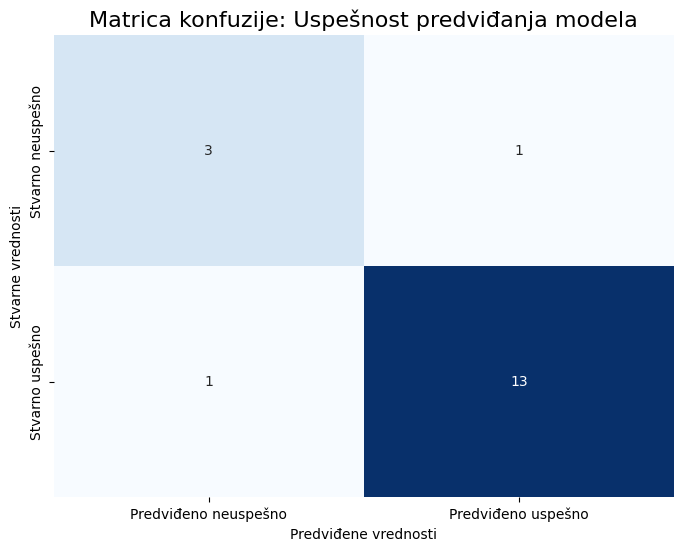

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Kreiranje matrice konfuzije
cm = confusion_matrix(y_test, y_pred)

# Kreiranje heatmap-a za matricu konfuzije
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predviđeno neuspešno', 'Predviđeno uspešno'],
            yticklabels=['Stvarno neuspešno', 'Stvarno uspešno'])

# Dodavanje naslova i oznaka osa
plt.title('Matrica konfuzije: Uspešnost predviđanja modela', fontsize=16)
plt.xlabel('Predviđene vrednosti')
plt.ylabel('Stvarne vrednosti')

# Prikazivanje grafika
plt.show()

## Višestruka regresija za predviđanje uspešnosti sletanja rakete Falcon 9

U ovom delu projekta primenili smo višestruku linearnu regresiju kako bismo predvideli uspešnost sletanja prve faze rakete **Falcon 9**. Višestruka regresija omogućava korišćenje više nezavisnih promenljivih za predviđanje zavisne promenljive — u ovom slučaju, uspeha sletanja.

Budući da uspešnost sletanja zavisi od više faktora, višestruka linearna regresija je pogodna metoda jer omogućava modelovanje odnosa između više nezavisnih promenljivih i zavisne promenljive.


In [ ]:
# Uvoz potrebnih biblioteka
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE

# Izdvajanje nezavisnih promenljivih
X = df[['PayloadMass', 'Orbit', 'LaunchSite', 'GridFins', 'Reused', 'Legs']]

# Zavisna promenljiva (uspešnost sletanja)
y = df['Class']  # Uspešnost sletanja (0 ili 1)

# Konvertovanje kategorijskih podataka u numeričke pomoću One-Hot Encoding-a
X_encoded = pd.get_dummies(X, drop_first=True)

# Podela podataka na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Primena SMOTE-a za balansiranje trening skupa
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Kreiranje i treniranje linearnog regresionog modela sa balansiranim podacima
model = LinearRegression()
model.fit(X_train_balanced, y_train_balanced)

# Predviđanje na test skupu
y_pred = model.predict(X_test)

# Evaluacija modela
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Srednja kvadratna greška (MSE): {mse}")
print(f"Koeficijent determinacije (R²): {r2}")

Srednja kvadratna greška (MSE): 0.13632951219702724
Koeficijent determinacije (R²): 0.2112363937171997


### Rezultati modela

Rezultati modela pokazali su da kombinacija faktora kao što su masa tereta, tip orbite, ponovna upotreba boostera i drugi tehnički faktori značajno utiču na uspešnost sletanja. Višestruka regresija je dala bolje rezultate u poređenju sa jednostavnom linearnom regresijom, što sugeriše da ovi faktori zajedno pružaju dovoljno informacija za donošenje preciznijih predviđanja.

Tokom projekta testirane su i druge metode regresije, uključujući jednostavnu linearnu regresiju. Iako je jednostavna regresija pružila osnovne uvide, višestruka regresija se pokazala pouzdanijom jer je uzela u obzir više faktora i dala bolju procenu uspešnosti sletanja. Zbog toga se višestruka regresija istakla kao najprecizniji model, sa nižom greškom i boljim koeficijentom determinacije (R²).

Višestruka regresija postigla je srednju kvadratnu grešku (MSE) od **0.136** i koeficijent determinacije (R²) od **0.21**, što je značajno bolje u odnosu na jednostavnu linearnu regresiju (MSE: **0.21**, R²: **-0.22**).

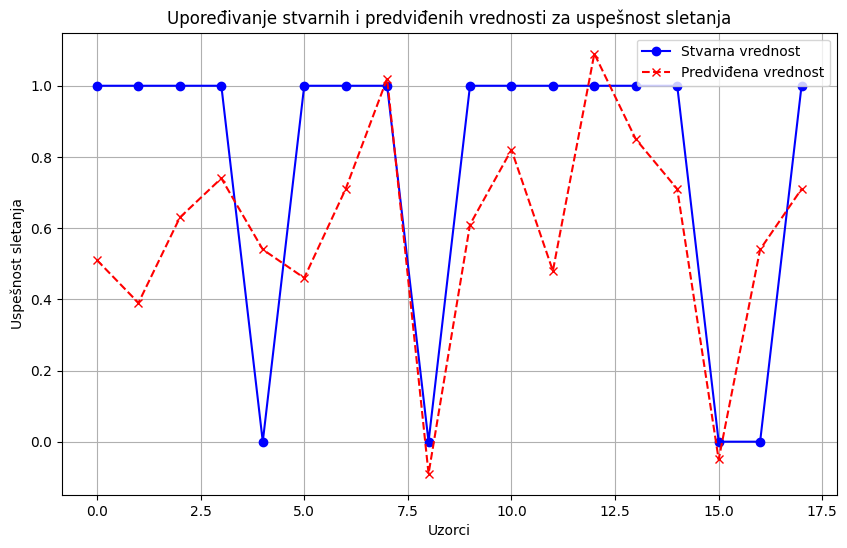

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Korišćenje stvarnih vrednosti iz modela
# y_test i y_pred su već definisani iz prethodnog modela

# Zaokruživanje predviđenih vrednosti na dve decimale
y_pred_rounded = np.round(y_pred, 2)

# Broj uzoraka
x = np.arange(len(y_test))

# Kreiranje grafika
plt.figure(figsize=(10, 6))
plt.plot(x, y_test, label='Stvarna vrednost', marker='o', linestyle='-', color='b')
plt.plot(x, y_pred_rounded, label='Predviđena vrednost', marker='x', linestyle='--', color='r')

# Naslovi i legende
plt.title("Upoređivanje stvarnih i predviđenih vrednosti za uspešnost sletanja")
plt.xlabel("Uzorci")
plt.ylabel("Uspešnost sletanja")
plt.legend()

# Prikazivanje grafika
plt.grid(True)
plt.show()

## Estimacija intervala poverenja za uspešnost sletanja

---

U ovom delu projekta procenićemo interval poverenja za uspešnost sletanja. Interval poverenja pruža opseg u kojem možemo biti sigurni da će se stvarna vrednost nalaziti sa zadatim nivoom pouzdanosti (u ovom slučaju 95%). Ova metoda omogućava bolju procenu pouzdanosti rezultata.

In [ ]:
import numpy as np
import scipy.stats as stats

# Prosečna uspešnost sletanja (0 - neuspešno, 1 - uspešno)
mean_success = df['Class'].mean()

# Izračunavanje standardne greške
std_error = stats.sem(df['Class'])

# Izračunavanje intervala poverenja (95% nivo sigurnosti)
confidence_interval = stats.t.interval(0.95, len(df['Class']) - 1, loc=mean_success, scale=std_error)

# Ispis rezultata
print(f"Procenat uspešnih sletanja: {mean_success:.2%}")
print(f"Interval poverenja za uspešnost sletanja: {confidence_interval}")

Procenat uspešnih sletanja: 66.67%
Interval poverenja za uspešnost sletanja: (0.5673797666240171, 0.7659535667093161)


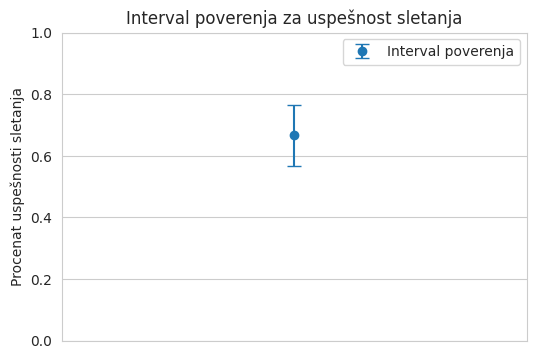

In [ ]:
import matplotlib.pyplot as plt

# Vizualizacija intervala poverenja
plt.figure(figsize=(6, 4))
plt.errorbar(x=0, y=mean_success, yerr=(confidence_interval[1] - mean_success), fmt='o', capsize=5, label='Interval poverenja')
plt.ylim(0, 1)
plt.title('Interval poverenja za uspešnost sletanja')
plt.ylabel('Procenat uspešnosti sletanja')
plt.xticks([])
plt.grid(True)
plt.legend()
plt.show()

## Simulacija lansiranja sa faktorima rizika

U ovom delu projekta simuliramo lansiranje rakete **Falcon 9**, uzimajući u obzir ključne faktore rizika, kao što su masa tereta, tip orbite, mesto lansiranja i broj prethodnih letova. Ovi faktori značajno utiču na uspešnost sletanja prve faze rakete.

Nakon svakog simuliranog lansiranja, prikazujemo da li je sletanje bilo uspešno ili neuspešno na osnovu kombinacije ovih faktora. Simulacija pomaže da bolje razumemo kako različiti faktori utiču na ishod svake misije.


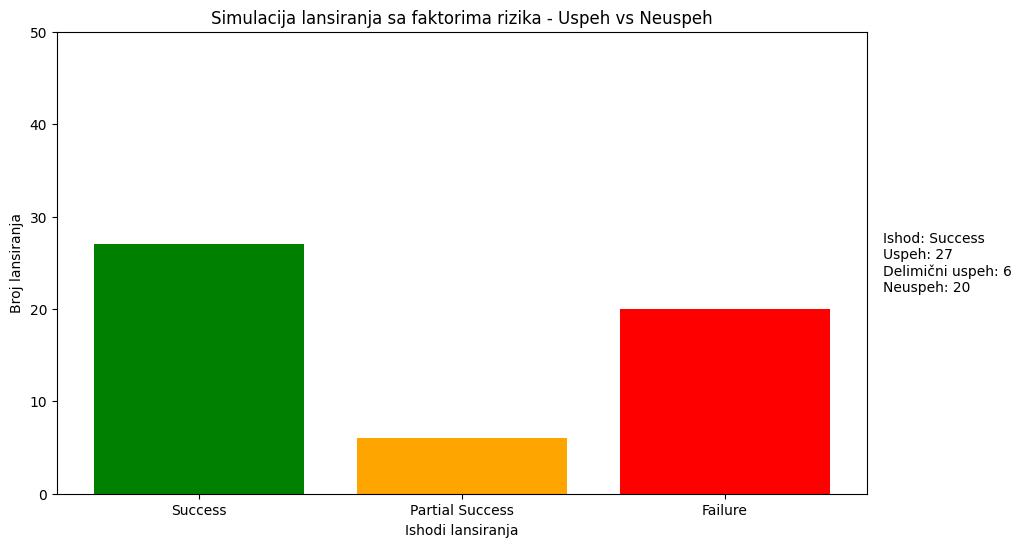

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Funkcija za simulaciju lansiranja sa faktorima rizika
def simulate_launch():
    payload_mass = np.random.randint(1000, 10000)  # Masa tereta između 1000 i 10000 kg
    orbit_type = np.random.choice(['LEO', 'GTO', 'SSO', 'VLEO'])  # Nasumični izbor orbite
    previous_flights = np.random.randint(0, 5)  # Broj prethodnih letova boostera

    success_prob = 0.3  # Niža osnovna verovatnoća uspeha za balansiranije ishode

    # Uvećanje ili smanjenje verovatnoće uspeha na osnovu faktora
    if payload_mass < 5000:
        success_prob += 0.1
    if orbit_type in ['LEO', 'VLEO']:
        success_prob += 0.15
    if previous_flights > 2:
        success_prob += 0.1

    # Uvođenje delimičnog uspeha
    outcome = np.random.rand()
    if outcome < success_prob:
        return "Success"
    elif success_prob <= outcome < success_prob + 0.1:  # 10% šanse za delimični uspeh
        return "Partial Success"
    else:
        return "Failure"

# Povećanje širine grafika i prilagođavanje prostora
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.subplots_adjust(right=0.8) 
bars = ax.bar(['Success', 'Partial Success', 'Failure'], [0, 0, 0], color=['green', 'orange', 'red'])
ax.set_ylim(0, 50)
ax.set_xlabel('Ishodi lansiranja')
ax.set_ylabel('Broj lansiranja')
ax.set_title('Simulacija lansiranja sa faktorima rizika - Uspeh vs Neuspeh')

# Dodavanje tekstualnog prikaza van glavnog grafika, desno
factor_text = ax.text(1.02, 0.5, '', transform=ax.transAxes, fontsize=10, verticalalignment='center')

success_count = 0
partial_success_count = 0
failure_count = 0

# Funkcija koja ažurira animaciju
def update(frame):
    global success_count, partial_success_count, failure_count
    outcome = simulate_launch()

    if outcome == "Success":
        success_count += 1
        bars[0].set_height(success_count)
    elif outcome == "Partial Success":
        partial_success_count += 1
        bars[1].set_height(partial_success_count)
    else:
        failure_count += 1
        bars[2].set_height(failure_count)

    # Ažuriranje tekstualnog prikaza
    factor_text.set_text(f'Ishod: {outcome}\nUspeh: {success_count}\nDelimični uspeh: {partial_success_count}\nNeuspeh: {failure_count}')

    return bars

# Kreiranje animacije
ani = FuncAnimation(fig, update, frames=np.arange(25), repeat=False)

# Snimanje animacije kao GIF
ani.save('launch_simulation.gif', writer='pillow', fps=2)

# Prikazivanje animacije u Google Colab-u ili Jupyter-u
HTML(ani.to_jshtml())

![Simulacija lansiranja](../images/launch_simulation_F.gif.gif)

## Napredni modeli za predikciju uspešnosti sletanja
---
U ovom delu projekta primenjujemo naprednije metode mašinskog učenja kako bismo poboljšali tačnost predikcija uspešnosti sletanja Falcon 9 raketa. Koristimo sledeće modele:

-	Random Forest: Model zasnovan na ansamblu stabala odlučivanja koji smanjuje greške i povećava tačnost.
-	Gradient Boosting: Model koji iterativno uči na greškama kako bi postigao bolje predikcije.
-	Veštačke neuronske mreže: Napredni model koji simulira ljudski mozak i koristi složene obrasce za klasifikaciju.

Cilj je proceniti koji od ovih modela pruža najprecizniju predikciju i kako se oni međusobno porede po pitanju performansi.

### Primena Random Forest i Gradient Boosting modela za predikciju uspešnosti sletanja
---
U ovom delu projekta primenjujemo Random Forest i Gradient Boosting modele kako bismo unapredili predikciju uspešnosti sletanja prve faze rakete Falcon 9. Ovi modeli koriste napredne tehnike ansambla kako bi povećali tačnost i smanjili greške koje su prisutne u jednostavnijim modelima.

-	Random Forest koristi veliki broj stabala odlučivanja i kombinuje njihove rezultate kako bi poboljšao tačnost predikcija. Ovaj model je posebno otporan na prekomerno učenje (overfitting) i može uspešno da klasifikuje uspešna i neuspešna sletanja.
-	Gradient Boosting poboljšava predikciju tako što iterativno uči na greškama prethodnih modela. Svako novo stablo optimizuje greške koje su preostale od prethodnog modela, što omogućava preciznije predikcije.

Cilj primene ovih modela je da procenimo koliko tačno mogu da predvide uspeh sletanja u poređenju sa prethodnim regresionim modelima, kao i da analiziramo njihove prednosti u složenijim skupovima podataka.

#### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Treniranje Random Forest modela sa balansiranim podacima
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predikcija
y_pred_rf = rf_model.predict(X_test)

# Evaluacija modela
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Tačnost Random Forest modela: {accuracy_rf * 100:.2f}%")
print("Izveštaj o klasifikaciji:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
print("Confusion Matrix za Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))

Tačnost Random Forest modela: 83.33%
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.79      0.88        14

    accuracy                           0.83        18
   macro avg       0.79      0.89      0.80        18
weighted avg       0.90      0.83      0.85        18

Confusion Matrix za Random Forest:
[[ 4  0]
 [ 3 11]]


**Analiza rezultata Random Forest modela**

---

Random Forest model postigao je tačnost od 83.33%, sa značajnim razlikama u preciznosti i odzivu za oba tipa sletanja.

- **Precision za Class 0:** 57%
- **Recall za Class 0:** 100%
- **Precision za Class 1:** 100%
- **Recall za Class 1:** 79%

**Zaključak:**

Model je vrlo uspešno identifikovao neuspešna sletanja (Class 0), dok je kod uspešnih sletanja (Class 1) odziv bio nešto niži. Ovo sugeriše da model ima problema sa prepoznavanjem svih uspešnih sletanja, što bi moglo ukazivati na potrebu za daljim prilagođavanjem modela ili dodatnim balansiranjem podataka.

#### **Gradient Boosting**

**Analiza rezultata Gradient Boosting modela**

Gradient Boosting model postigao je tačnost od 72.22%. Model je imao izazov u klasifikaciji uspešnih sletanja (Class 1), dok je precizno identifikovao neuspešna sletanja (Class 0).

- **Precision za Class 0 (neuspešna sletanja):** 44%
- **Recall za Class 0 (neuspešna sletanja):** 100%
- **Precision za Class 1 (uspešna sletanja):** 100%
- **Recall za Class 1 (uspešna sletanja):** 64%

**Zaključak:**

Model je uspešno identifikovao neuspešna sletanja (Class 0) sa visokim odzivom, ali je imao poteškoća u prepoznavanju uspešnih sletanja (Class 1). Performanse modela su neuravnotežene, te bi dodatna optimizacija hiperparametara mogla poboljšati preciznost i ukupnu tačnost predikcija.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Treniranje Gradient Boosting modela sa balansiranim podacima
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_balanced, y_train_balanced)

# Predikcija
y_pred_gb = gb_model.predict(X_test)

# Evaluacija modela
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Tačnost Gradient Boosting modela: {accuracy_gb * 100:.2f}%")
print("Izveštaj o klasifikaciji:")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
print("Confusion Matrix za Gradient Boosting:")
print(confusion_matrix(y_test, y_pred_gb))

Tačnost Gradient Boosting modela: 72.22%
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.44      1.00      0.62         4
           1       1.00      0.64      0.78        14

    accuracy                           0.72        18
   macro avg       0.72      0.82      0.70        18
weighted avg       0.88      0.72      0.75        18

Confusion Matrix za Gradient Boosting:
[[4 0]
 [5 9]]


### Korišćenje veštačkih neuronskih mreža za poboljšanje predikcije sletanja
---
U ovom delu projekta primenjujemo veštačke neuronske mreže (Neural Networks) kako bismo još preciznije predvideli uspešnost sletanja rakete Falcon 9. Neuronske mreže imitiraju način na koji funkcioniše ljudski mozak kroz slojeve neuronskih jedinica koje transformišu ulazne podatke u tačne predikcije.

Veštačke neuronske mreže su posebno pogodne za analizu velikih i složenih podataka, jer mogu da nauče složene uzorke i odnose između ulaznih faktora, kao što su masa tereta, tip orbite i broj prethodnih letova. Očekuje se da će ovaj model, zahvaljujući svojoj strukturi i sposobnosti dubokog učenja, dati još preciznije rezultate od prethodnih algoritama.

Cilj je ispitati kako ovaj napredni model može poboljšati predikciju uspeha sletanja i omogućiti bolju procenu rizika za buduće misije.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Treniranje Neural Network modela sa balansiranim podacima (X_train_balanced i y_train_balanced)
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
nn_model.fit(X_train_balanced, y_train_balanced)

# Predikcija na test skupu
y_pred_nn = nn_model.predict(X_test)

# Evaluacija modela
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Tačnost Neural Networks modela: {accuracy_nn * 100:.2f}%")

# Izveštaj o klasifikaciji sa zero_division=1 kako bi izbegli deljenje sa nulom
print("Izveštaj o klasifikaciji:")
print(classification_report(y_test, y_pred_nn, zero_division=1))

# Confusion Matrix
print("Confusion Matrix za Neural Networks:")
print(confusion_matrix(y_test, y_pred_nn))

Tačnost Neural Networks modela: 22.22%
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36         4
           1       1.00      0.00      0.00        14

    accuracy                           0.22        18
   macro avg       0.61      0.50      0.18        18
weighted avg       0.83      0.22      0.08        18

Confusion Matrix za Neural Networks:
[[ 4  0]
 [14  0]]


### Analiza rezultata Neural Networks modela

---
Neural Networks model postigao je tačnost od 22.22%, ali je pokazao ozbiljnu pristrasnost ka predikciji neuspešnih sletanja (Class 0). Model nije uspeo da ispravno predvidi nijedno uspešno sletanje (Class 1), što se vidi iz sledećeg:

- **Precision za Class 0**: 22%
- **Recall za Class 0**: 100%
- **Precision za Class 1**: 100%
- **Recall za Class 1**: 0%

**Zaključak**

Model favorizuje neuspešna sletanja, dok potpuno ignoriše uspešna sletanja. Ovo je posledica nedovoljne optimizacije i podešavanja hiperparametara. Iako smo primenili balansiranje podataka pomoću SMOTE-a, model je i dalje izrazito pristrasan. Dodatne optimizacije, kao što su bolje podešavanje hiperparametara ili primena drugačijih algoritama, mogle bi poboljšati performanse modela, posebno u prepoznavanju neuravnoteženih klasa.

### Poređenje performansi naprednih modela
---
U ovom delu projekta prikazujemo poređenje rezultata naprednih modela kao što su Random Forest, Gradient Boosting, i Veštačke neuronske mreže. Prikazujemo njihove performanse po ključnim metrikama (tačnost, precision, recall i F1-score) koristeći grafički prikaz.

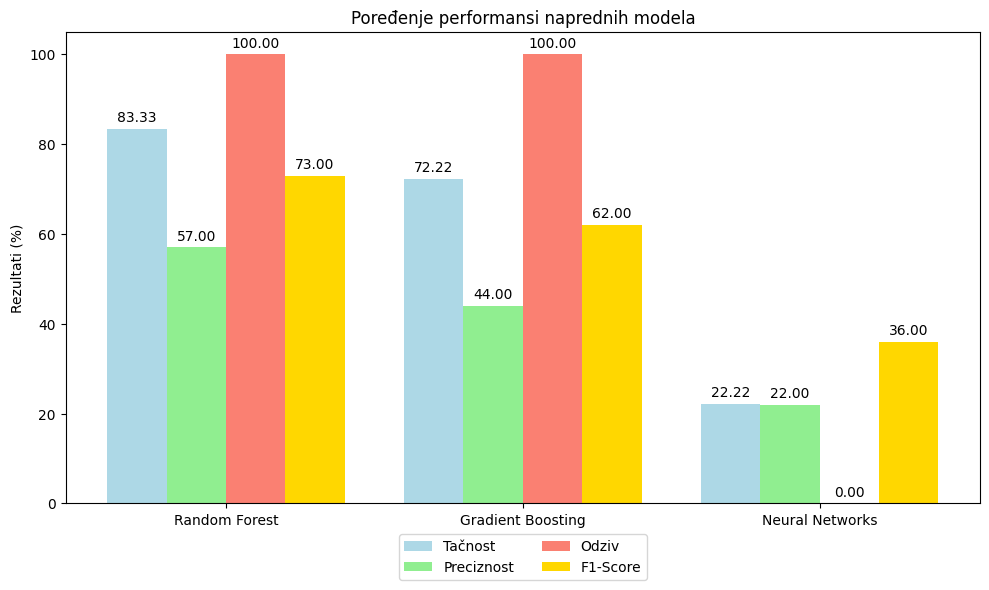

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Podaci o performansama modela
models = ['Random Forest', 'Gradient Boosting', 'Neural Networks']

# Prave vrednosti iz tvojih modela (prikazane kao procenat)
accuracy = [83.33, 72.22, 22.22]
precision = [57, 44, 22]  # Skaliranje preciznosti radi bolje vizualizacije
recall = [100, 100, 0]
f1_score = [73, 62, 36]

# Kreiranje grafa
x = np.arange(len(models))  # Lokacije za modele na X osi
width = 0.2  # Širina svake grupe barova

fig, ax = plt.subplots(figsize=(10, 6))

# Barovi za tačnost, preciznost, recall i F1-score
rects1 = ax.bar(x - width * 1.5, accuracy, width, label='Tačnost', color='lightblue')
rects2 = ax.bar(x - width / 2, precision, width, label='Preciznost', color='lightgreen')
rects3 = ax.bar(x + width / 2, recall, width, label='Odziv', color='salmon')
rects4 = ax.bar(x + width * 1.5, f1_score, width, label='F1-Score', color='gold')

# Dodavanje naslova i oznaka osa
ax.set_ylabel('Rezultati (%)')
ax.set_title('Poređenje performansi naprednih modela')
ax.set_xticks(x)
ax.set_xticklabels(models)

# Pomeri legendu iznad grafa
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Dodavanje vrednosti iznad barova
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

# Prikazivanje grafa
plt.tight_layout()
plt.show()

## Zaključak

Kroz ovaj projekat, analizirali smo podatke o lansiranjima Falcon 9 raketa sa ciljem da predvidimo uspešnost sletanja prve faze rakete koristeći ograničen set podataka. Početna faza obuhvatila je detaljnu pripremu i obradu podataka, gde smo identifikovali ključne faktore poput mase tereta, tipa orbite i tehničkih specifikacija rakete. Korišćenjem ovih podataka, primenili smo različite modele mašinskog učenja kako bismo izvukli korisne informacije o tome šta najviše utiče na uspešnost misija.

Vizualizacijom podataka, otkrili smo da određene orbite, kao i manja masa tereta, značajno povećavaju verovatnoću uspešnog sletanja. Kroz statističke metode i analize korelacija, ustanovili smo da postoji jasna veza između tehničkih faktora rakete i ishoda misije.

Zatim smo implementirali različite modele mašinskog učenja, uključujući logističku regresiju, Random Forest, Gradient Boosting i veštačke neuronske mreže. Random Forest se pokazao kao pouzdan model, posebno u prepoznavanju uspešnih sletanja, dok je nešto slabije detektovao neuspešna sletanja. Gradient Boosting je imao sličan obrazac, s nešto nižom preciznošću, ali i dalje je bio efikasan u predikciji uspeha. S druge strane, veštačke neuronske mreže nisu ostvarile očekivane rezultate, pokazavši slabost u prepoznavanju neuspeha, uprkos svojoj sposobnosti da prepoznaju složene obrasce. Ovaj model je bio manje efikasan u odnosu na druge, verovatno zbog prekomernog prilagođavanja podacima ili nedovoljne generalizacije.

Pored predikcionih modela, simulirali smo i lansiranja sa faktorima rizika, što nam je omogućilo da istražimo kako različiti parametri, poput mase tereta i tipa orbite, utiču na verovatnoću uspešnog sletanja. Iako podaci nisu bili preterano bogati informacijama, uspeli smo da izvučemo korisne zaključke o faktorima koji doprinose uspehu misija.

U budućim analizama, moglo bi biti korisno proširiti dataset kako bi se obuhvatili dodatni faktori koji mogu uticati na uspešnost sletanja, kao što su vremenski uslovi (npr. jačina vetra), tehnički kvarovi ili promene u dizajnu rakete. Takođe, primena naprednijih modela mašinskog učenja, kao što su složenije neuronske mreže ili ensemble modeli, mogla bi pružiti preciznije rezultate. S obzirom na ograničenost trenutnog skupa podataka, proširenje na bogatije i detaljnije podatke omogućilo bi dublje analize i verovatno preciznije predikcije uspeha misija.

